In [26]:
# !pip install tensorflow-gpu==1.14.0

In [1]:
%load_ext autoreload
%autoreload 2

from classification_models.tfkeras import Classifiers
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tf.enable_eager_execution()

keras = tf.keras
K = tf.keras.backend

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
import iic_datasets_ops
import iic_loss_ops
import utils
import models
import mnist_ops

In [3]:
batch_size = 64
num_classes = 10
num_repeats = 2
input_shape = (28, 28, 1)
num_train_steps = 60000 // batch_size
num_eval_steps = 10000 // batch_size

In [4]:
train_dataset, dataset_info = tfds.load(name="mnist", split=tfds.Split.TRAIN, as_supervised=True, with_info=True)
test_dataset = tfds.load(name="mnist", split=tfds.Split.TEST, as_supervised=True)

In [5]:
train_dataset

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [6]:
first_image_aug_fn = iic_datasets_ops.get_default_image_aug_fn(rotation=0, skew=0, translation=0, crop=0.4, uniform_noise=0)
second_image_aug_fn = iic_datasets_ops.get_default_image_aug_fn()

# # first_image_aug_fn = mnist_ops.mnist_x_aug_fn
# # second_image_aug_fn = mnist_ops.mnist_gx_aug_fn

iic_train_dataset, model_input_shape = iic_datasets_ops.prepare_dataset(
    dataset=train_dataset,
    first_image_aug_fn=first_image_aug_fn,
    second_image_aug_fn=second_image_aug_fn,
    batch_size=batch_size,
    num_image_repeats=num_repeats,
    input_size=input_shape[:2],
)

cls_train_dataset, _ = iic_datasets_ops.prepare_dataset(
    dataset=train_dataset.take(200),
    first_image_aug_fn=first_image_aug_fn,
    second_image_aug_fn=second_image_aug_fn,
    batch_size=batch_size,
    num_image_repeats=num_repeats,
    input_size=input_shape[:2],
)

iic_test_dataset, _ = iic_datasets_ops.prepare_dataset(
    dataset=train_dataset,
    first_image_aug_fn=mnist_ops.get_mnist_test_x_aug_fn(input_shape),
    second_image_aug_fn=mnist_ops.get_mnist_test_x_aug_fn(input_shape),
    batch_size=batch_size,
    num_image_repeats=num_repeats,
    input_size=input_shape[:2],
)

Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


In [7]:
iic_train_dataset, iic_test_dataset

(<DatasetV1Adapter shapes: ({image: (?, 28, 28, 1), tf_image: (?, 28, 28, 1)}, {label: (?,)}), types: ({image: tf.float32, tf_image: tf.float32}, {label: tf.int64})>,
 <DatasetV1Adapter shapes: ({image: (?, 28, 28, 1), tf_image: (?, 28, 28, 1)}, {label: (?,)}), types: ({image: tf.float32, tf_image: tf.float32}, {label: tf.int64})>)

In [8]:
model_input_shape

[28, 28, 1]

In [9]:
iic_train_iterator = iic_train_dataset.make_one_shot_iterator()
iic_test_iterator = iic_test_dataset.make_one_shot_iterator()
iic_train_iterator, iic_test_iterator

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


(<tensorflow.python.data.ops.iterator_ops.IteratorV2 at 0x7eff6d5c84a8>,
 <tensorflow.python.data.ops.iterator_ops.IteratorV2 at 0x7eff6d5a2898>)

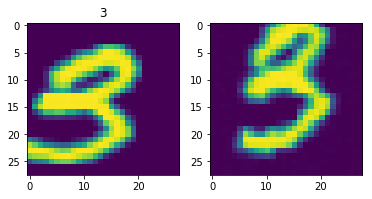

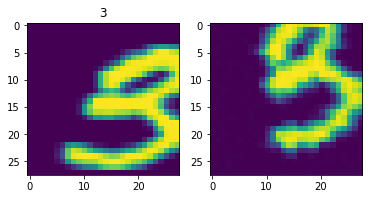

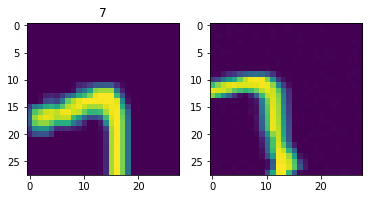

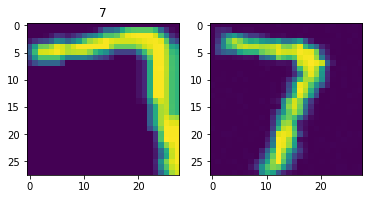

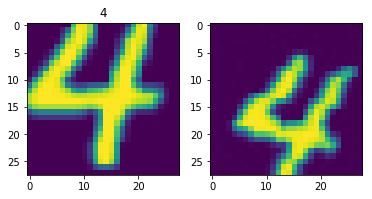

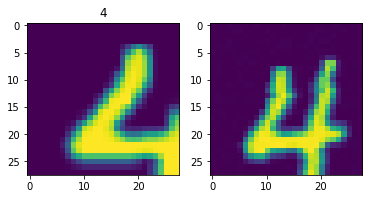

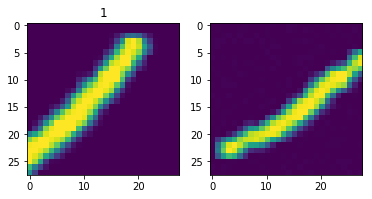

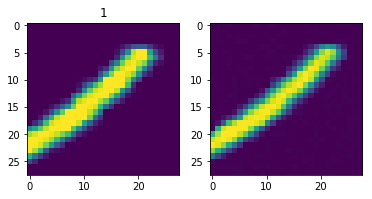

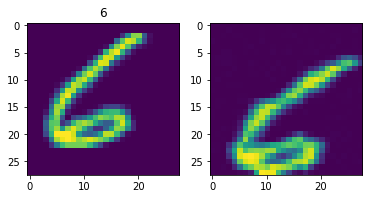

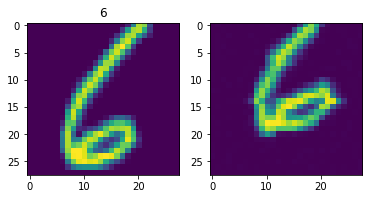

In [10]:
utils.plot_image_pairs(*next(iic_train_iterator), num_examples=10)

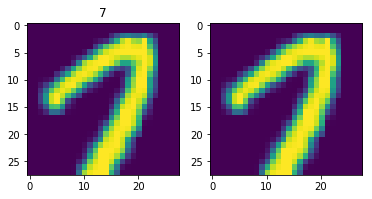

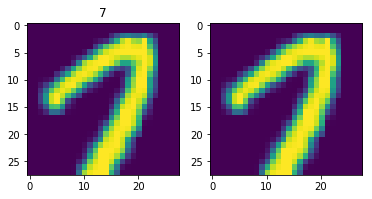

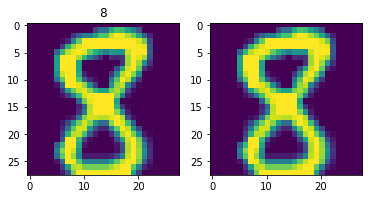

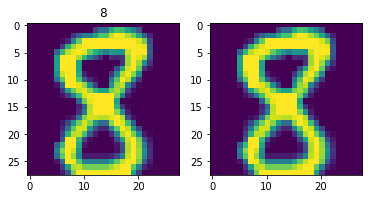

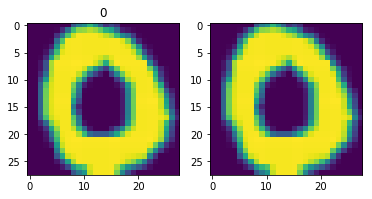

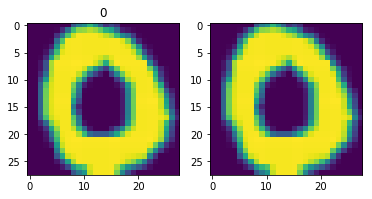

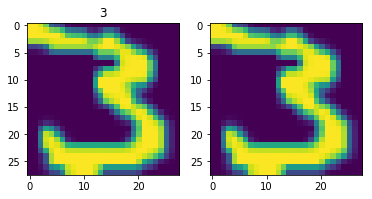

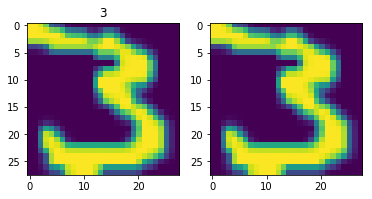

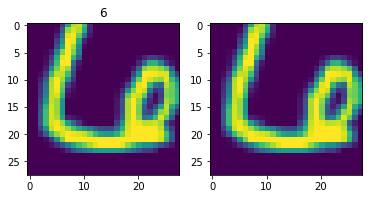

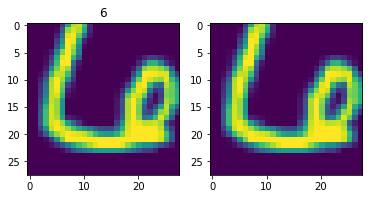

In [11]:
utils.plot_image_pairs(*next(iic_test_iterator), num_examples=10)

In [12]:
%timeit -n 10 next(iic_train_iterator)

The slowest run took 176.05 times longer than the fastest. This could mean that an intermediate result is being cached.
7.3 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
base_model = models.create_resnet_se_backbone(model_input_shape, (1, 1), attention=None)

In [14]:
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 28, 28, 1)    3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 34, 34, 1)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 14, 14, 64)   3136        zero_padding2d[0][0]             
______________________________________________________________________________________________

In [15]:
iic_prediction_model = models.create_iic_model(
    base_model, 
    main_heads_num_classes=[num_classes], 
    aux_heads_num_classes=[5 * num_classes],
)

In [16]:
iic_prediction_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 4, 4, 128)    312387      image[0][0]                      
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 128)          0           model[1][0]                      
__________________________________________________________________________________________________
aux_head_0/dense (Dense)        (None, 50)           6450        global_average_pooling2d[0][0]   
____________________________________________________________________________________________

In [17]:
# inputs, main_heads, aux_heads
image_input = keras.Input(shape=model_input_shape, name="image")
tf_image_input = keras.Input(shape=model_input_shape, name="tf_image")

image_predictions = iic_prediction_model(image_input)
tf_image_predictions = iic_prediction_model(tf_image_input)

In [18]:
image_predictions

{'main_heads': [<tf.Tensor 'model_1/Identity_1:0' shape=(?, 10) dtype=float32>],
 'aux_heads': [<tf.Tensor 'model_1/Identity:0' shape=(?, 50) dtype=float32>]}

In [19]:
num_main_heads = len(image_predictions['main_heads'])
num_aux_heads = len(image_predictions['aux_heads'])

heads_p_out = image_predictions['main_heads']
heads_p_tf_out = tf_image_predictions['main_heads']

main_heads_loss = tf.add_n([
    iic_loss_ops.iic_loss(
        heads_p_out[k], 
        heads_p_tf_out[k])
    for k in range(num_main_heads)
]) / num_main_heads

aux_heads_loss = tf.add_n([
    iic_loss_ops.iic_loss(
        image_predictions['aux_heads'][k], 
        tf_image_predictions['aux_heads'][k]) 
    for k in range(num_aux_heads)
]) / num_aux_heads

main_heads_loss, aux_heads_loss

(<tf.Tensor 'truediv_2:0' shape=() dtype=float32>,
 <tf.Tensor 'truediv_5:0' shape=() dtype=float32>)

In [20]:
inputs = {
    "image": image_input,
    "tf_image": tf_image_input
}

iic_main_model = keras.Model(inputs=inputs, outputs=heads_p_out)
iic_aux_model = keras.Model(inputs=inputs, outputs=heads_p_tf_out)

In [21]:
iic_main_model.layers[-1].get_layer("aux_head_0/dense").trainable = False

In [22]:
iic_main_model.add_loss(main_heads_loss)
iic_aux_model.add_loss(aux_heads_loss)

In [23]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
iic_main_model.compile(optimizer=optimizer)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
iic_aux_model.compile(optimizer=optimizer)

In [27]:
iic_main_model.fit(
    iic_train_iterator, verbose=1, epochs=3,
    steps_per_epoch=num_train_steps, 
    callbacks=[utils.PredictionsHistory(iic_test_iterator, interval=20)]
)

Epoch 1/3
937/937 [==============================] - 36s 38ms/step - loss: -1.8700
Epoch 2/3
937/937 [==============================] - 36s 38ms/step - loss: -1.9001
Epoch 3/3
937/937 [==============================] - 35s 38ms/step - loss: -1.9134


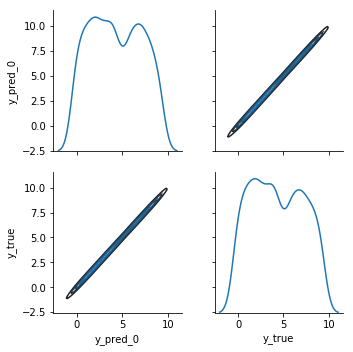

In [103]:
utils.plot_probabilities_grid(iic_main_model, iic_test_iterator)

In [24]:
labels = tf.keras.layers.Lambda(lambda x: x, name="label")(image_predictions['main_heads'][0])
cls_model = keras.Model(inputs={"image": image_input}, outputs=labels)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
cls_model.compile(optimizer=optimizer, loss={"label": "sparse_categorical_crossentropy"})

In [25]:
cls_model.fit(
    cls_train_dataset, verbose=1, epochs=2,
    steps_per_epoch=100, callbacks = [utils.PredictionsHistory(iic_test_iterator)]
)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  1/100 [..............................] - ETA: 11:55 - loss: 2.3464WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.165330). Check your callbacks.


100/100 [==============================] - 10s 97ms/step - loss: 0.6730
Epoch 2/5
100/100 [==============================] - 2s 24ms/step - loss: 0.1821
Epoch 3/5
100/100 [==============================] - 2s 24ms/step - loss: 0.1092
Epoch 4/5
100/100 [==============================] - 2s 25ms/step - loss: 0.0801
Epoch 5/5
100/100 [==============================] - 2s 25ms/step - loss: 0.0764
